### Validation for 2020-08-28 onboarding customer score run
---

In [84]:
import pickle as pkl
import numpy as np
import pandas as pd

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
# from train import features, preprocess, encode_defaults, default_values
from src.utils import scale_scores
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-poster')
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

### Data Preprocessing

In [2]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score', 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
#     df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

In [3]:
# get scores
model = pkl.load(open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb'))

In [4]:
# production data
# prod_path = '../../data-production/2020-08-28_onboarding-customer-model-data.csv'
# prod_path = '../../data-production/2020'
# prod_df = pd.read_csv(prod_path, index_col=0)
prod_df = pkl.load(open('../../data-production/2020-09-19_kraken_rg_test_active_accounts.pickle', 'rb'))
prod_df['model_score'] = prod_df.model_score.astype(float)
prod_df['created_dt'] = pd.to_datetime(prod_df.created_dt)

# pred and scores get from dev model
prod_df['dev_pred'] = model.predict_proba(prod_df[features])[:, 1]
prod_df['dev_score'] = scale_scores(prod_df['dev_pred'])

In [5]:
# # dev data from dw
modeling_df = pd.read_feather('../../data/combined_all_features/combined_1600789121.feather')
modeling_df, _ = encode_defaults(modeling_df, default_values)
modeling_df = modeling_df[modeling_df.is_static]
modeling_df.loc[:, 'party_id'] = modeling_df['user_id']
modeling_df = modeling_df[modeling_df.sample_date == pd.to_datetime('2020-09-18')]
modeling_df = preprocess(modeling_df)
modeling_df['pred'] = model.predict_proba(modeling_df[features])[:, 1]
modeling_df['score'] = scale_scores(modeling_df['pred'])

### EDA on dfs

In [8]:
# trim dfs
id_dict = get_overlap_and_diff(modeling_df.party_id, prod_df.party_id)
shared_id = id_dict['shared']

<AxesSubplot:>

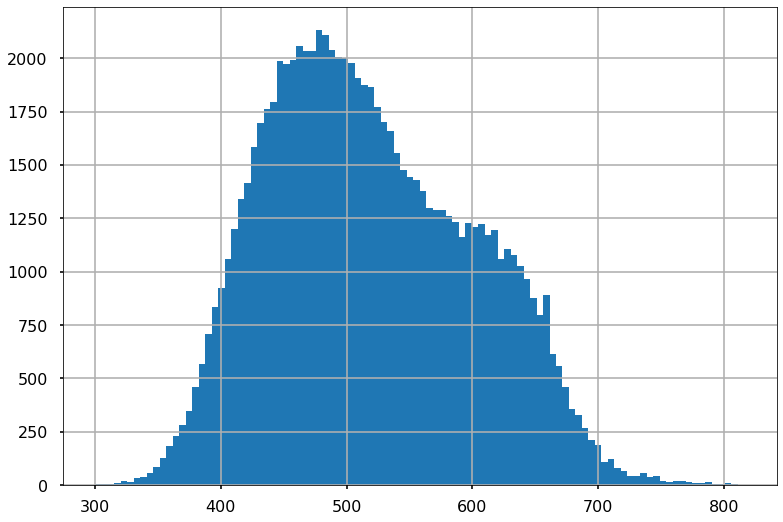

In [9]:
prod_df.dev_score.hist(bins=100)

<AxesSubplot:>

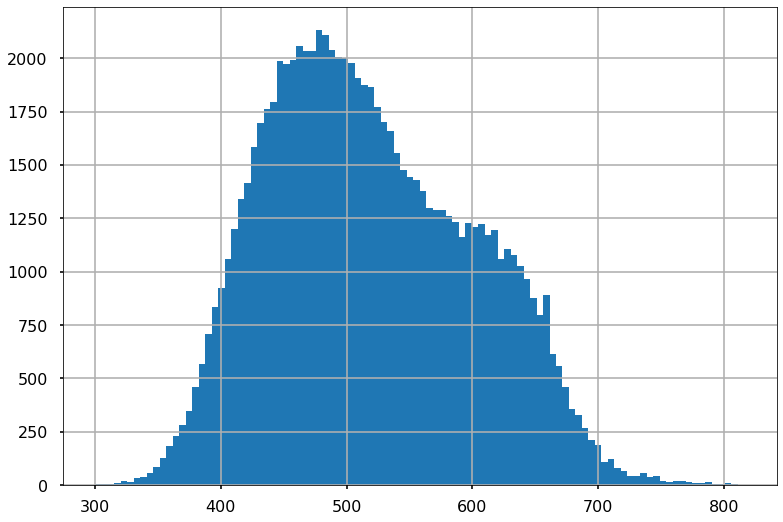

In [10]:
prod_df.model_score.hist(bins=100)

### Template
---

In [23]:
# get data
# prod_df = pkl.load(open('../../data/production-results/2020-08-05_full-customer-model-data.pickle', 'rb'))
prod_df = pkl.load(open('../../data-production/2020-09-19_kraken_rg_test_active_accounts.pickle', 'rb'))
prod_df['score'] = prod_df.model_score.astype(float)
prod_df['created_dt'] = pd.to_datetime(prod_df.created_dt)
# prod_df = preprocess(prod_df)

modeling_df = pd.read_feather('../../data/combined_all_features/combined_1600789121.feather')
modeling_df = modeling_df[modeling_df.sample_date == pd.to_datetime('2020-09-18')]
modeling_df, _ = encode_defaults(modeling_df, default_values)
modeling_df.loc[:, 'party_id'] = modeling_df['user_id']

In [24]:
# # produce scores
model = pkl.load(open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb'))

In [25]:
modeling_df = preprocess(modeling_df)
modeling_df['pred'] = model.predict_proba(modeling_df[features])[:, 1]
modeling_df['score'] = scale_scores(modeling_df['pred'])

In [26]:
# include active inactive accounts
active_accounts = modeling_df[(modeling_df.nr_past_transactions > 0) & (modeling_df.nr_transactions_30d > 0)].party_id.unique()
modeling_df['is_active'] = modeling_df.party_id.isin(active_accounts)
prod_df['is_active'] = prod_df.party_id.isin(active_accounts)

In [27]:
# trimming dfs
id_dict = get_overlap_and_diff(prod_df.party_id, modeling_df.party_id)
shared_id = id_dict['shared']
shared_cols = modeling_df.columns.intersection(prod_df.columns)
modeling_df = modeling_df[modeling_df.party_id.isin(shared_id)].drop_duplicates(subset='party_id')
prod_df = prod_df[prod_df.party_id.isin(shared_id)].drop_duplicates(subset='party_id')

In [28]:
modeling_df = modeling_df.sort_values('party_id', ).reset_index(drop=True)
prod_df = prod_df.sort_values('party_id').reset_index(drop=True)

In [29]:
# # remove inactive accounts

# null_df = prod_df[prod_df.score == prod_df.score.value_counts().index[0]]
# null_accounts = null_df.party_id
# dormant_shared_ids = modeling_df.party_id.isin(null_accounts)
# modeling_df = modeling_df[~modeling_df.party_id.isin(dormant_shared_ids)].drop_duplicates(subset='party_id')
# prod_df = prod_df[~prod_df.party_id.isin(dormant_shared_ids)].drop_duplicates(subset='party_id')

#### Functionalities
---

In [30]:
combined_df = get_combined_dfs(modeling_df, prod_df, 'party_id')

((83724, 113), (83724, 52))

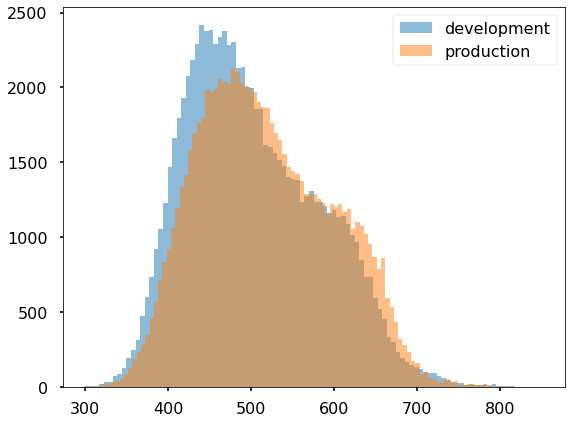

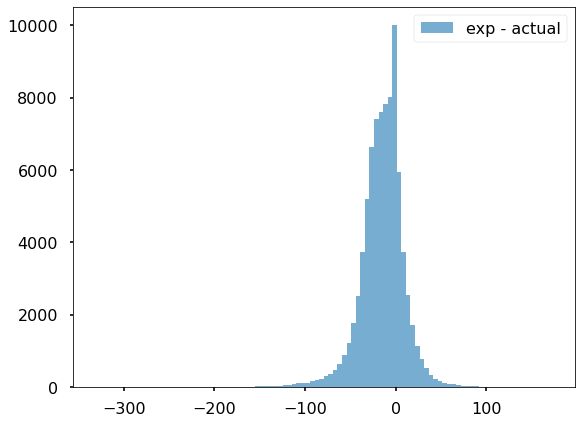

In [31]:
_ = plot_score_dist(modeling_df.score, prod_df.score, bins=100)
psi_df = get_psi(modeling_df[features], prod_df[features])

_ = plot_difference(modeling_df.score, prod_df.score, bins=100)
modeling_df.shape, prod_df.shape

In [109]:
len(modeling_df)

71519

In [32]:
psi_df = get_psi(modeling_df[features], prod_df[features], buckets=4)
psi_df.head(10)

,feature,psi
38,transaction_code_encoded,0.018064
26,time_since_last_transaction,0.013083
31,nr_trans_ratio,0.007892
6,transaction_as_pct_of_balance,0.007568
15,nr_past_transactions,0.007449
27,bal_ratio,0.006937
25,nr_direct_deposits,0.005932
11,lag_acc_open_first_transaction,0.005763
35,credit_card_loan_amount,0.003379
24,giact_nr_decline,0.000856


In [33]:
# report = get_feature_comparison_report(modeling_df, prod_df, 
#                                        'party_id', title='post-imp-report', 
#                                        cols=psi_df.head(6).feature.tolist(),
#                                        save_path='./feature-comparison-report')

### Look into troublesome features
---

In [34]:
# first filter out inactive accounts
modeling_df = modeling_df[modeling_df.is_active]
prod_df = prod_df[prod_df.is_active]

In [35]:
psi_df = get_psi(modeling_df[features], prod_df[features])
psi_df.head()

,feature,psi
31,nr_trans_ratio,0.092371
38,transaction_code_encoded,0.034857
26,time_since_last_transaction,0.019233
25,nr_direct_deposits,0.018440
24,giact_nr_decline,0.015448


((71519, 113), (71519, 52))

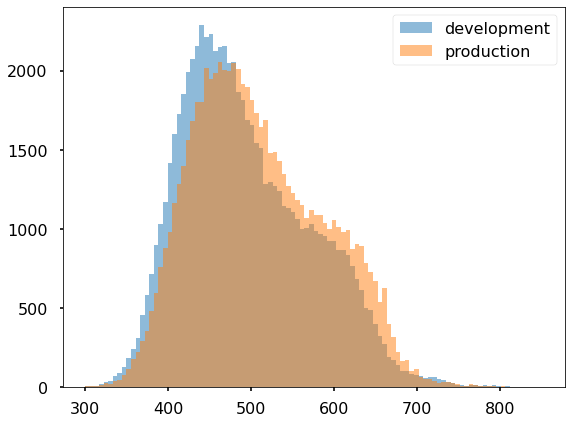

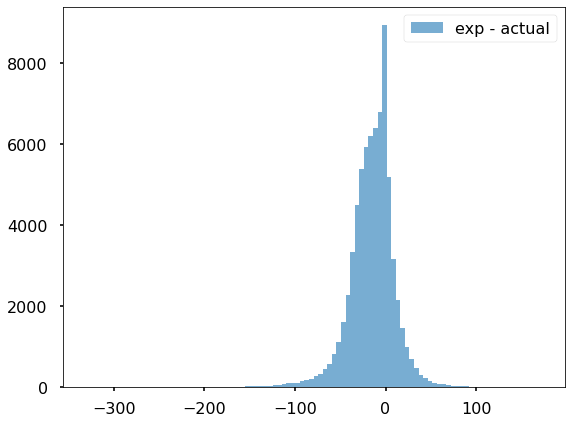

In [74]:
_ = plot_score_dist(modeling_df.score, prod_df.score, bins=100)
psi_df = get_psi(modeling_df[features], prod_df[features])

_ = plot_difference(modeling_df.score, prod_df.score, bins=100)
modeling_df.shape, prod_df.shape

True

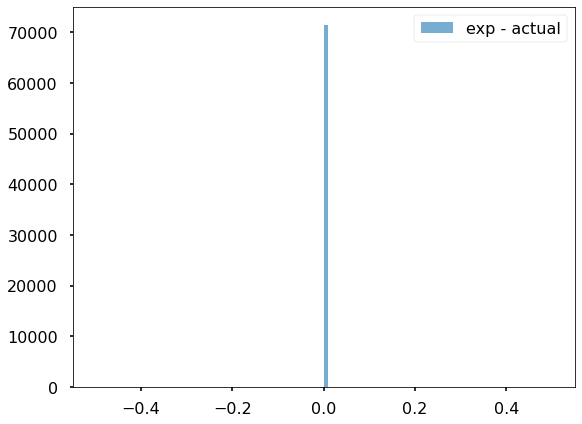

In [106]:
prod_df['dev_pred'] = model.predict_proba(prod_df[features])[:, 1]
prod_df['dev_score'] = scale_scores(prod_df['dev_pred'])
_ = plot_difference(prod_df.dev_score, prod_df.score, bins=100)
prod_df.dev_score.equals(prod_df.score)

In [101]:
cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score', 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

id_samples = combined_df[combined_df.score_exp == combined_df.score_act].party_id.unique()[:30]
modeling_df[modeling_df.party_id.isin(id_samples)][["score"] + features].to_csv('../../artifacts/post-implementation-testing/custom-tests/additional_tests.csv')

### Risk Group

In [ ]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

combined_df['RG_dev'] = get_risk_groups(combined_df.score_exp)
combined_df['RG_prod'] = get_risk_groups(combined_df.score_act)
# combined_df.columns[combined_df.columns.str.contains('score')]
# combined_df[['score_exp', 'score_act']].head(10)

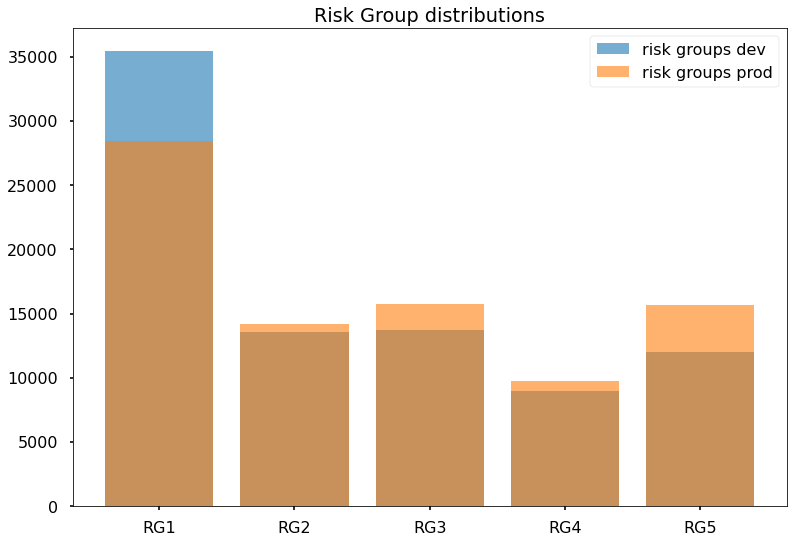

In [88]:
fig = plt.figure()
data = combined_df.RG_dev.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='risk groups dev')
data = combined_df.RG_prod.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='risk groups prod')
plt.legend()
plt.title('Risk Group distributions')
fig.savefig('../../artifacts/post-implementation-testing/risk-group-distributions.png')

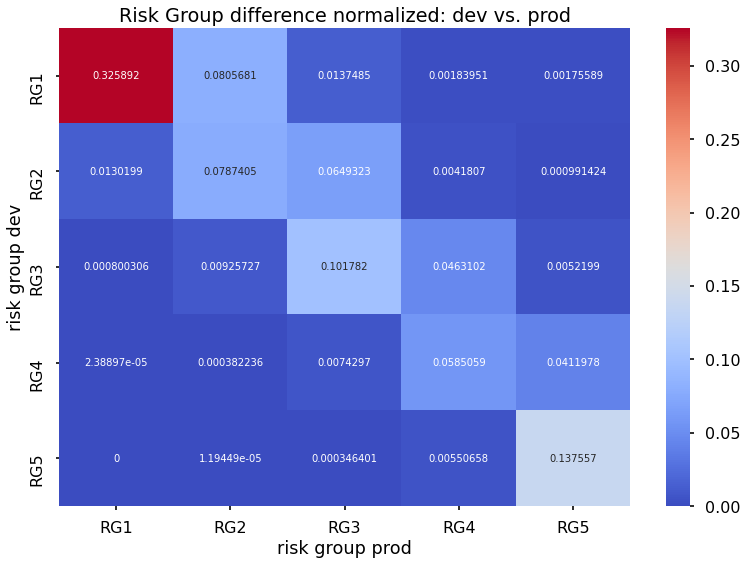

In [89]:
table = combined_df[['RG_dev', 'RG_prod']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['risk group dev', 'risk group prod', 'counts']
table = pd.pivot_table(table, values='counts', index='risk group dev', 
                       columns='risk group prod', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group difference normalized: dev vs. prod')
fig.savefig('../../artifacts/post-implementation-testing/risk-group-shifts-normalized.png')

In [37]:
psi_df.head()

,feature,psi
31,nr_trans_ratio,0.092371
38,transaction_code_encoded,0.034857
26,time_since_last_transaction,0.019233
25,nr_direct_deposits,0.018440
24,giact_nr_decline,0.015448


In [58]:
def plot_score_dist(dev_score, prod_score, figsize=(9,7), 
                    dev_label='development', prod_label='production',
                    bins=10, title=''):
    """ Compare distributions of two scores
    @params dev_score: sequence of scores
    @params prod_score: sequence of scores
    @params figsize: tuple
    @returns fig: plt.figure object
    """
    fig = plt.figure(figsize=figsize)
    _, bins, _ = plt.hist(dev_score, bins=bins, alpha=0.5, label=dev_label)
    plt.hist(prod_score, bins, alpha=0.5, label=prod_label)
    plt.legend()
    plt.title(title)
    return fig

### All Features

In [39]:
cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score', 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']


In [49]:
psi_df = get_psi(modeling_df[cols_raw], prod_df[cols_raw])
psi_df.round(5)

,feature,psi
31,nr_trans_ratio,0.09237
26,time_since_last_transaction,0.01923
25,nr_direct_deposits,0.01844
24,giact_nr_decline,0.01545
15,nr_past_transactions,0.01451
6,transaction_as_pct_of_balance,0.01011
11,lag_acc_open_first_transaction,0.00977
35,credit_card_loan_amount,0.00924
27,bal_ratio,0.00832
30,dollar_val_returns,0.00698


In [71]:
psi_df.round(5).to_csv('../../artifacts/post-implementation-testing/psi.csv', index=False)

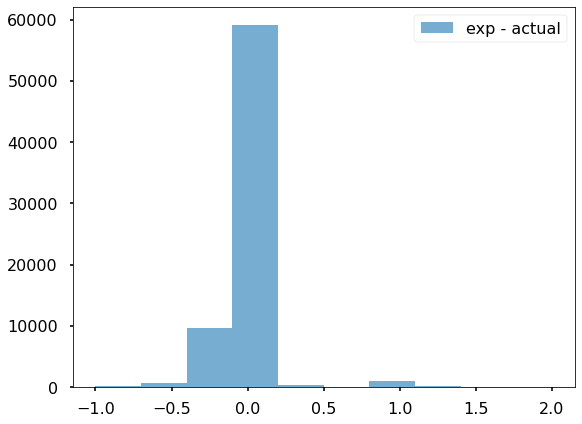

In [41]:
f = 'nr_trans_ratio'
# idx = (modeling_df[f] >= 0) & (prod_df[f] >= 0)
# idx = (modeling_df[f] >= 0.4) & (prod_df[f] >= 0.4)
_ = plot_difference(modeling_df[f], prod_df[f], bins=10)

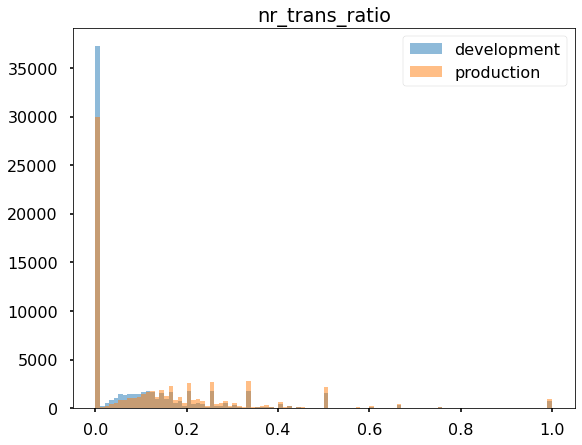

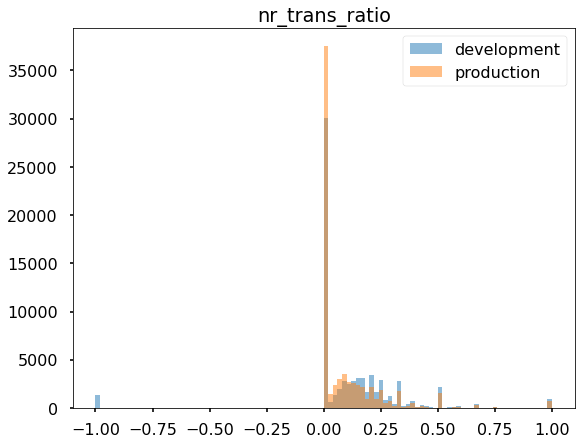

In [42]:
f = 'nr_trans_ratio'
_ = plot_score_dist(modeling_df[f], prod_df[f], bins=100, title=f)
_ = plot_score_dist(prod_df[f], modeling_df[f], bins=100, title=f)

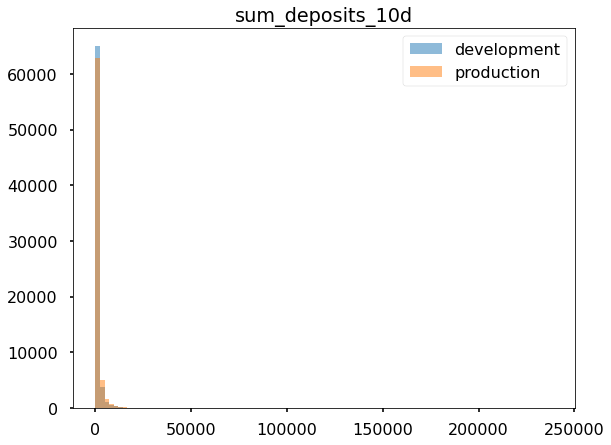

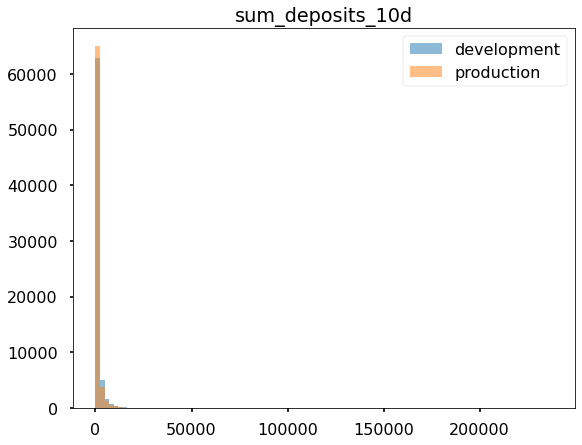

In [43]:
f = 'sum_deposits_10d'
_ = plot_score_dist(modeling_df[f], prod_df[f], bins=100, title=f)
_ = plot_score_dist(prod_df[f], modeling_df[f], bins=100, title=f)

### Plot for all features

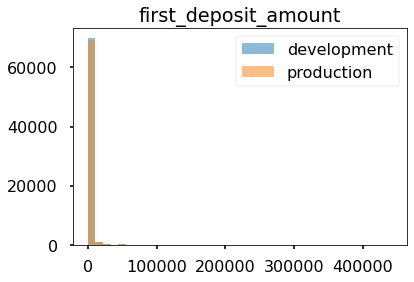

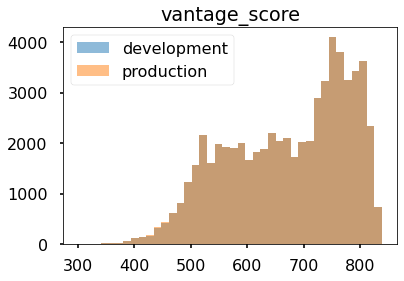

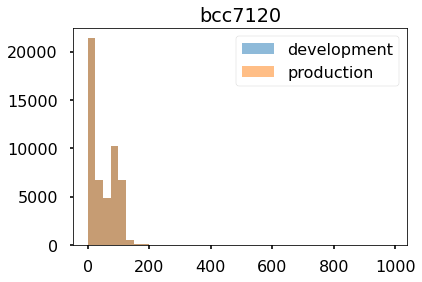

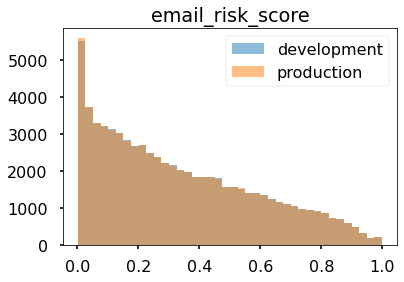

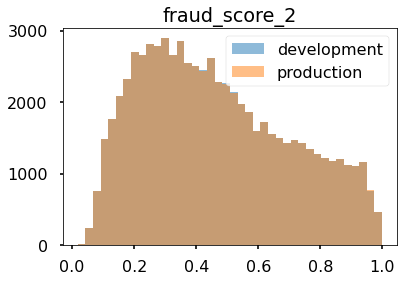

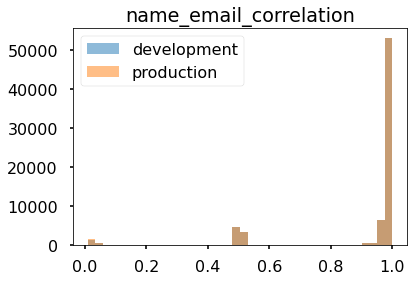

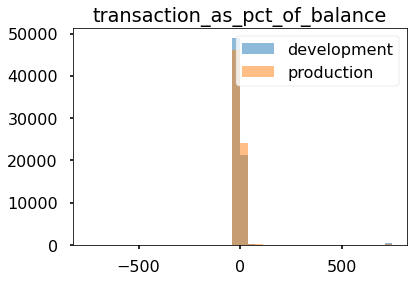

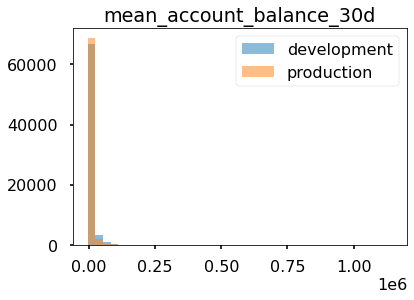

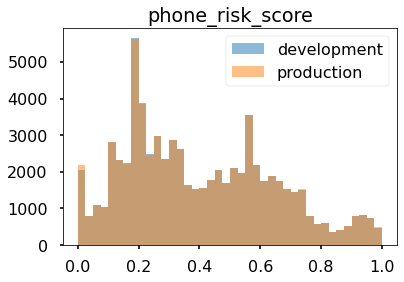

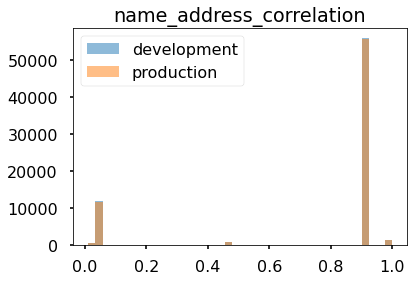

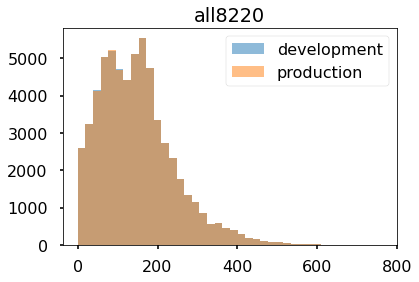

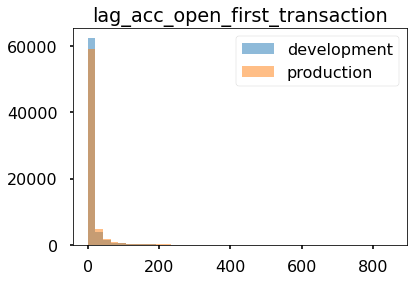

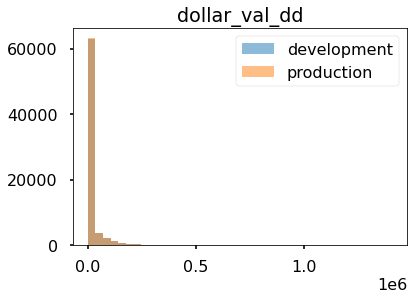

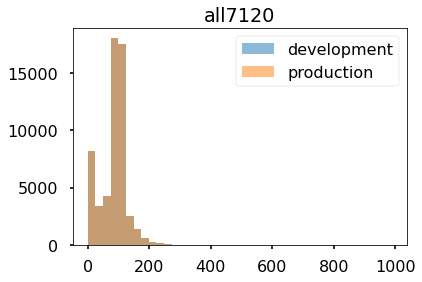

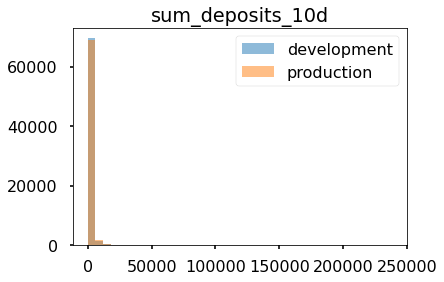

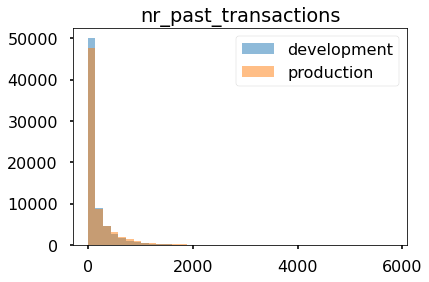

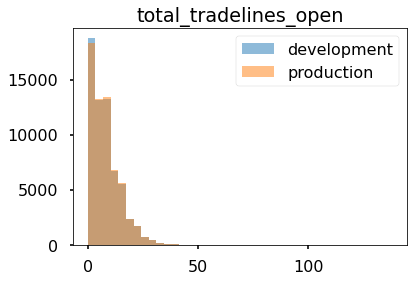

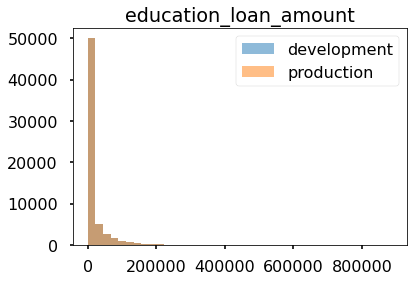

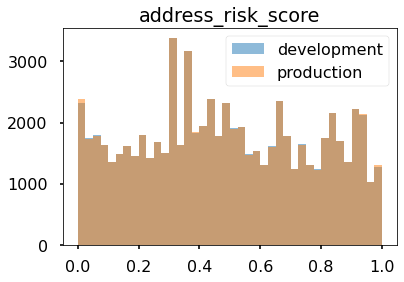

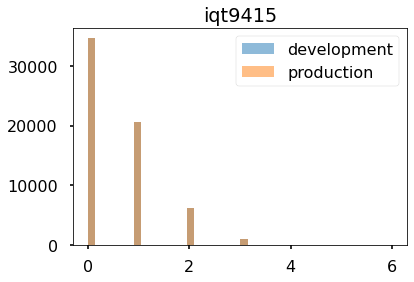

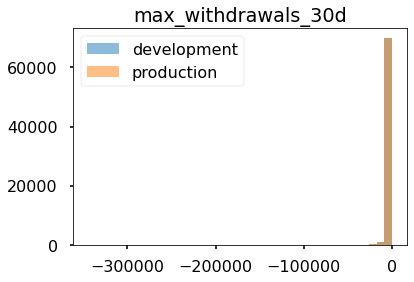

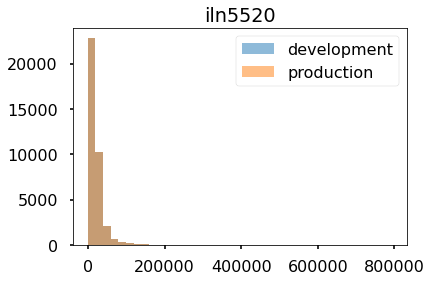

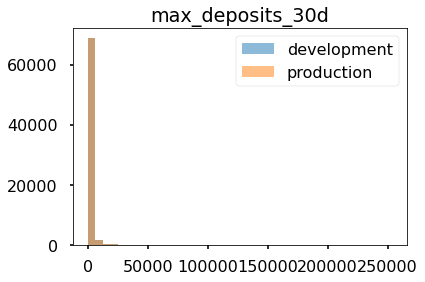

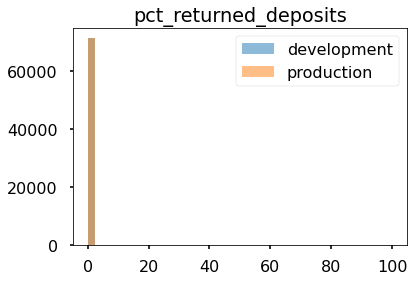

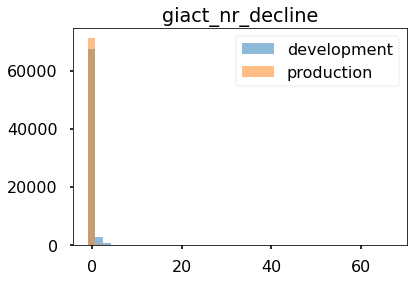

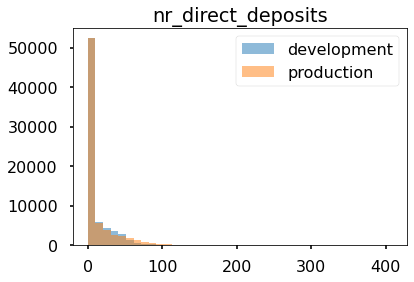

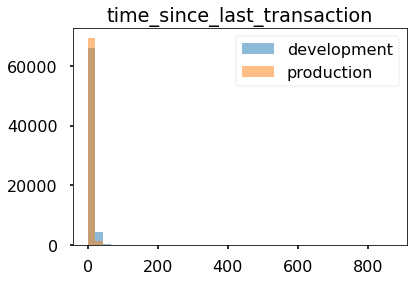

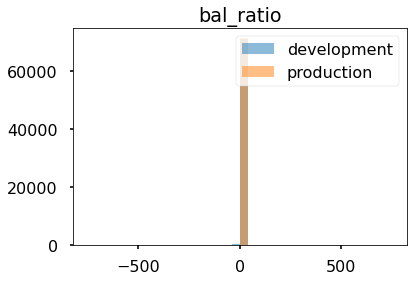

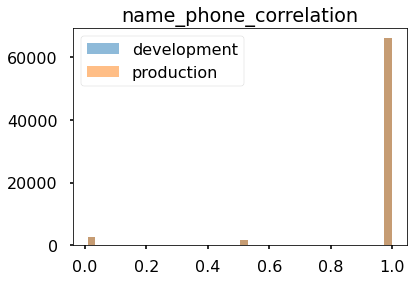

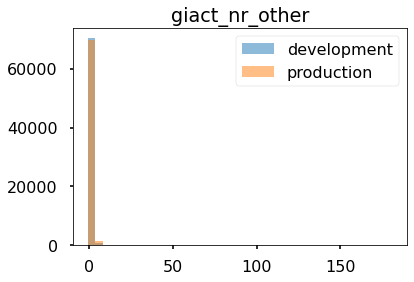

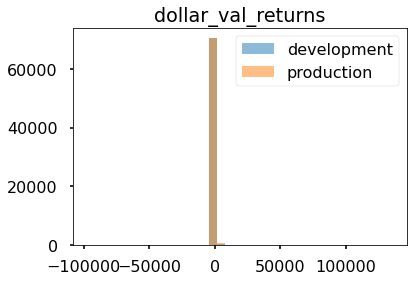

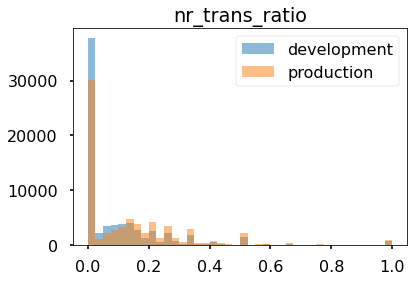

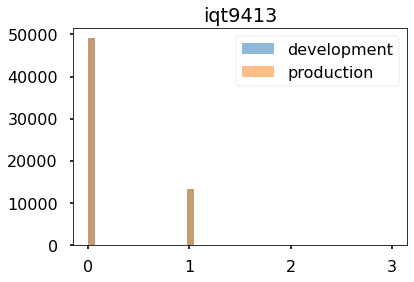

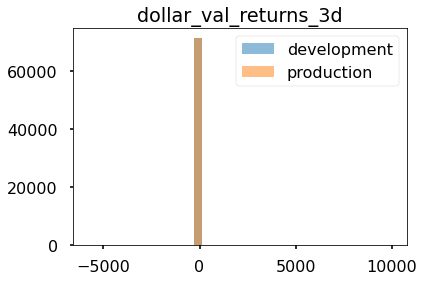

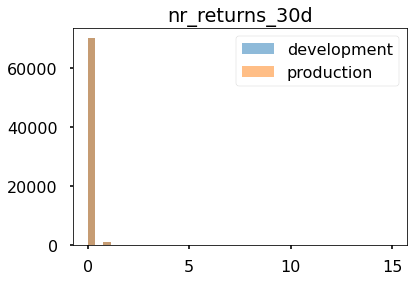

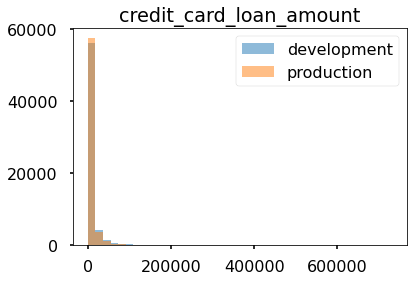

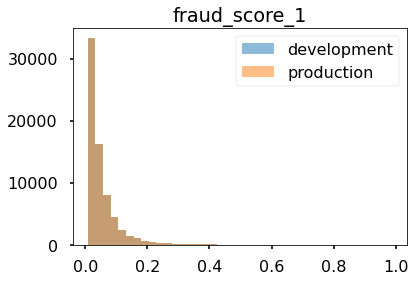

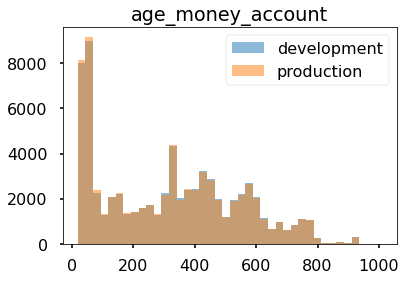

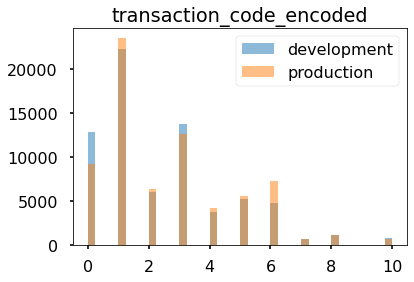

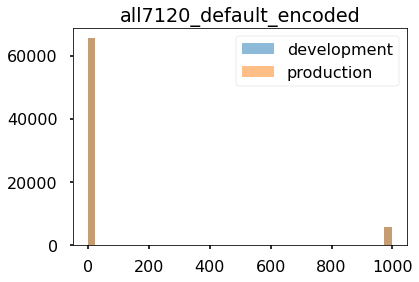

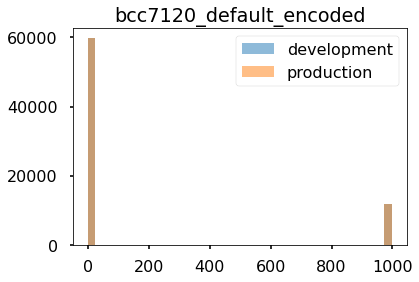

In [68]:
for f in features:
    try:
        idx = ~(modeling_df[f].isna() | prod_df[f].isna())
        fig = plot_score_dist(modeling_df[idx][f], prod_df[idx][f], bins=40, title=f, figsize=(6,4))
        fig.savefig(f'../../artifacts/post-implementation-testing/features/{f}.png')
    except:
        print(f, " issue")